In [1]:
# %load_ext autoreload
# %autoreload 2

import sys
sys.path.append('..')

%env WORKDIR=/Users/jitang/Dev/workdir

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from eofs.xarray import Eof
import cartopy.crs as ccrs

from lib.reanalysis import r1
from lib import obs
from lib.plotting import maps
from lib.enso import oni_trimonthly

env: WORKDIR=/Users/jitang/Dev/workdir


In [634]:
sfo = obs.daily_summary('SFO', '1980-07-01', '2021-06-01')
sfo.loc[sfo.day == '2008-01-03', 'precip_in'] = 0.17
sfo.loc[sfo.day == '2008-01-04', 'precip_in'] = 2.10
sfo.loc[sfo.day == '2008-01-05', 'precip_in'] = 0.77
sfo.loc[sfo.precip_in < 0.1, 'precip_in'] = 0

data_cols = ['day', 'precip_in', 'max_temp_f', 'min_temp_f', 'climo_high_f', 'climo_low_f']

sfo_modified = sfo[data_cols]
sfo_modified['max_temp_anom'] = sfo_modified.max_temp_f - sfo_modified.climo_high_f
sfo_modified['min_temp_anom'] = sfo_modified.min_temp_f - sfo_modified.climo_low_f

sfo_monthly = sfo_modified[['day', 'precip_in', 'max_temp_anom', 'min_temp_anom']].resample('MS', on='day').agg({
    'precip_in': np.sum,
    'max_temp_anom': np.mean,
    'min_temp_anom': np.mean
}).reset_index()

djf = sfo_monthly[sfo_monthly.day.dt.month.isin([12, 1, 2, 3])]

<ipython-input-634-0210faffa1db>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sfo_modified['max_temp_anom'] = sfo_modified.max_temp_f - sfo_modified.climo_high_f
<ipython-input-634-0210faffa1db>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sfo_modified['min_temp_anom'] = sfo_modified.min_temp_f - sfo_modified.climo_low_f


In [635]:
djf.precip_in.describe()

count    164.000000
mean       3.397195
std        2.757524
min        0.000000
25%        1.205000
50%        2.780000
75%        5.175000
max       13.520000
Name: precip_in, dtype: float64

In [639]:
# wet_top50 = djf[djf.precip_in > djf.precip_in.mean() + 0.5*djf.precip_in.std()]
# wet_top50.shape

wet_top50 = djf.sort_values(by='precip_in', ascending=False).head(50)
wet_top50.shape

(50, 4)

In [640]:
oni = oni_trimonthly()
wet_top50['month'] = wet_top50.day.dt.month
wet_top50['year'] = wet_top50.day.dt.year

oni_relevant = oni[['ANOM', 'MONTH', 'YR']]
oni_relevant.columns = ['ONI', 'month', 'year']
wet_top50 = wet_top50.merge(oni_relevant)

In [641]:
bbox = (0, 360, 90, 10)
_, _, wet_anoms = r1.hgt_monthly(500, yearmonths=wet_top50.day, bbox=bbox)

In [727]:
coslat = np.cos(np.deg2rad(wet_anoms.coords['lat'].values))
coslat[coslat < 0] = 0
wgts = np.sqrt(coslat)[..., np.newaxis]

solver = Eof(wet_anoms.hgt, weights=wgts)

# retrieve the first two EOFs from the solver class
eofs = solver.eofs(neofs=3)

In [728]:
solver.varianceFraction(neigs=3)

<xarray.DataArray 'variance_fractions' (mode: 3)>
array([0.20243254, 0.17504643, 0.10479441], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2
Attributes:
    long_name:  variance_fractions

In [644]:
def plot_nhem_anoms(da, cmap, levels, title, draw=True, colorbar_label='Geopotential height anomaly (dm)'):
    proj = ccrs.NorthPolarStereo(central_longitude=-94.5, true_scale_latitude=None, globe=None)
    m = maps.CartopyMap(proj=proj)
    if draw:
        m.draw()
    m.plot.fill(da, cmap, levels, colorbar=True, colorbar_label=colorbar_label)
    m.textbox.bottom_right(title, fontsize=20)
    m.textbox.top_left('by Jim Tang (@wxmann)', fontsize=16)
    return m

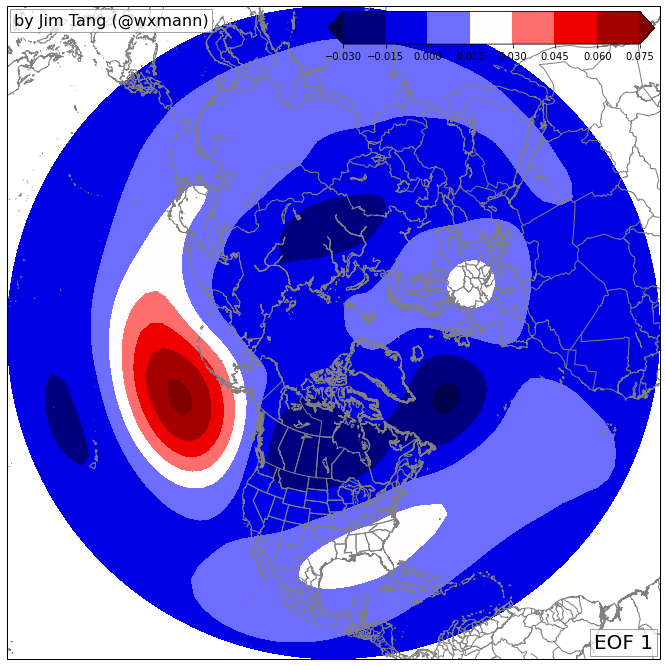

In [729]:
fig = plt.figure(figsize=(12, 12))

da = eofs[0]
cmap = 'seismic'
title = 'EOF 1'

m = plot_nhem_anoms(da, cmap, levels=None, title=title, draw=True, colorbar_label=None)

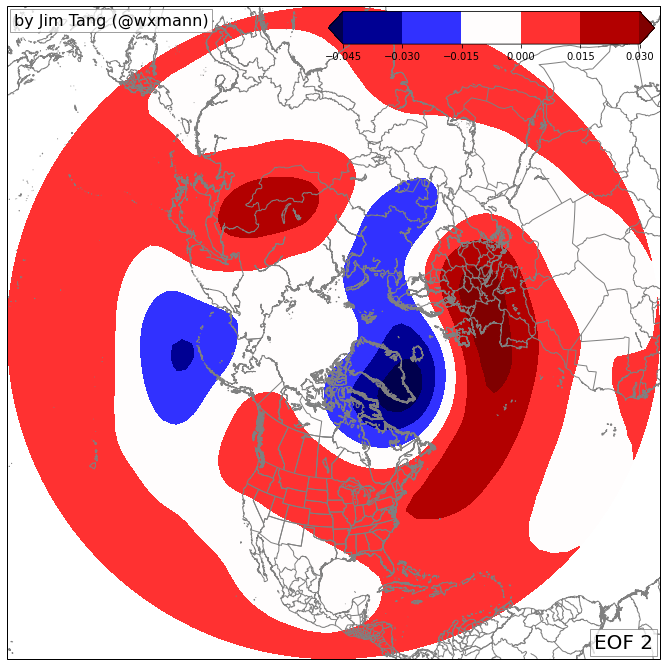

In [730]:
fig = plt.figure(figsize=(12, 12))

da = eofs[1]
cmap = 'seismic'
title = 'EOF 2'

m = plot_nhem_anoms(da, cmap, levels=None, title=title, draw=True, colorbar_label=None)

In [731]:
pcs = solver.pcs(pcscaling=1, npcs=2).to_dataframe().reset_index()
first_pc = pcs[pcs['mode'] == 0]
second_pc = pcs[pcs['mode'] == 1]
wet_with_pcs = wet_top50.merge(
    first_pc[['time', 'pcs']], left_on='day', right_on='time').merge(
    second_pc[['time', 'pcs']], on='time')

wet_with_pcs = wet_with_pcs.rename(columns={
    'pcs_x': 'pc1',
    'pcs_y': 'pc2'
})

In [732]:
in_djf = wet_with_pcs.day.dt.month.isin([12, 1, 2])
wet_with_pcs_djf = wet_with_pcs[in_djf]

in_djfm = wet_with_pcs.day.dt.month.isin([12, 1, 2, 3])
wet_with_pcs_djfm = wet_with_pcs[in_djfm]

In [743]:
wet_with_pcs_djfm

day  precip_in  max_temp_anom  min_temp_anom  month  year   ONI  \
0  1998-02-01      13.52      -2.785714       1.446429      2  1998  1.93   
1  1993-01-01      11.07      -1.080645      -1.235484      1  1993  0.09   
2  2014-12-01      10.47       4.983871       7.341935     12  2014  0.66   
3  2008-01-01       9.87      -3.269677      -0.520645      1  2008 -1.64   
4  2002-12-01       9.37       1.177419       3.019355     12  2002  1.14   
5  2017-01-01       9.19       0.145161      -0.493548      1  2017 -0.34   
6  1982-01-01       8.80      -5.145161      -5.235484      1  1982 -0.05   
7  1995-01-01       8.76      -0.241935       4.216129      1  1995  0.96   
8  1995-03-01       8.63      -2.070968      -0.025806      3  1995  0.53   
9  2001-12-01       8.27      -0.564516       2.664516     12  2001 -0.31   
10 1983-03-01       8.26      -3.103226       1.490323      3  1983  1.54   
11 2005-12-01       8.17       2.435484       3.277419     12  2005 -0.84   
12 2000-02-01       8.15      -1.724138       2.458621      2  2000 -1.41   
13 1986-02-01       7.87       2.642857       4.339286      2  1986 -0.47   
14 1998-01-01       7.77       0.983871       4.312903      1  1998  2.24   
15 1982-03-01       7.49      -5.167742      -2.251613      3  1982  0.19   
16 1997-01-01       7.35      -1.177419       2.119355      1  1997 -0.50   
17 2017-02-01       7.24       0.285714       2.875000      2  2017 -0.16   
18 2019-02-01       7.20      -3.607143      -2.232143      2  2019  0.72   
19 1996-01-01       6.84       0.758065       2.377419      1  1996 -0.90   
20 1983-01-01       6.75      -2.758065      -1.332258      1  1983  2.18   
21 1983-02-01       6.55      -1.178571       1.982143      2  1983  1.92   
22 1996-12-01       6.49       2.274194       4.696774     12  1996 -0.49   
23 1995-12-01       6.27       1.983871       4.212903     12  1995 -0.98   
24 2004-12-01       6.26       1.403226       1.696774     12  2004  0.69   
25 2009-02-01       6.24      -1.392857      -0.267857      2  2009 -0.79   
26 2012-12-01       6.23       0.693548       1.793548     12  2012 -0.21   
27 1992-02-01       6.22       3.103448       2.941379      2  1992  1.63   
28 2003-12-01       6.09       0.306452       2.277419     12  2003  0.35   
29 1983-12-01       6.03       0.661290       4.954839     12  1983 -0.91   
30 2001-02-01       5.98      -3.071429      -1.267857      2  2001 -0.52   
31 1991-03-01       5.96      -4.361290      -1.122581      3  1991  0.22   
32 2010-01-01       5.94      -0.661290       2.635484      1  2010  1.50   
33 1992-12-01       5.92      -1.403226      -0.529032     12  1992 -0.13   
34 1986-03-01       5.83       1.670968       2.522581      3  1986 -0.31   
35 2010-12-01       5.80       0.112903       2.890323     12  2010 -1.59   
36 1996-02-01       5.75       0.758621       2.837931      2  1996 -0.75   
37 1981-01-01       5.72       0.306452       1.248387      1  1981 -0.26   
38 2000-01-01       5.65       1.145161       3.474194      1  2000 -1.66   
39 2006-03-01       5.63      -5.167742      -3.896774      3  2006 -0.57   
40 2016-01-01       5.31       0.693548       4.183871      1  2016  2.48   
41 2011-03-01       5.13      -2.232258      -0.154839      3  2011 -0.93   
42 1994-02-01       5.12      -2.964286      -1.839286      2  1994  0.07   
43 2016-03-01       5.05       1.767742       3.877419      3  2016  1.58   
44 2005-02-01       4.82       0.857143       3.267857      2  2005  0.58   
45 2018-01-01       4.82       2.822581       3.893548      1  2018 -0.92   
46 2011-02-01       4.79      -1.321429      -3.303571      2  2011 -1.19   
47 2012-03-01       4.67      -2.135484      -1.187097      3  2012 -0.59   
48 1993-02-01       4.54      -1.392857       0.767857      2  1993  0.30   
49 2016-12-01       4.51       0.080645      -2.432258     12  2016 -0.56   

         time       pc1       pc2  
0  1998-02-01 -1.064628  1.712914  
1  1993-01

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


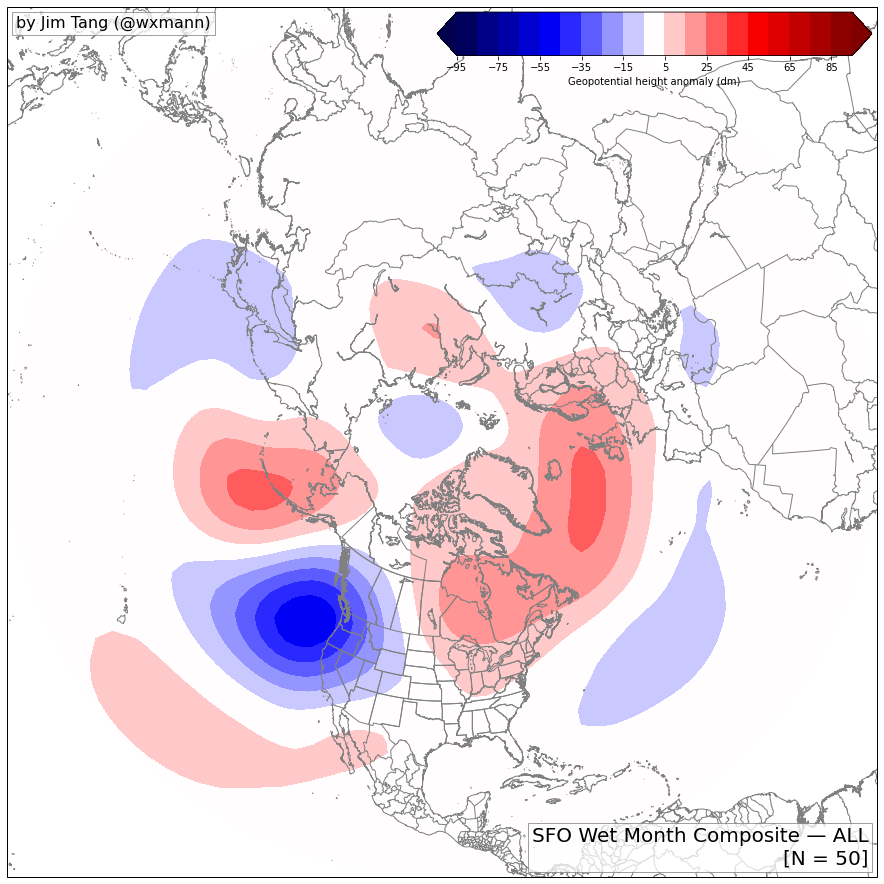

In [733]:
fig = plt.figure(figsize=(16, 16))

_, _, wet_with_pcs_djfm_anoms = r1.hgt_monthly(500, yearmonths=wet_with_pcs_djfm.day, bbox=bbox)
da = wet_with_pcs_djfm_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = np.arange(-95, 96, 10)
title = f'SFO Wet Month Composite — ALL\n[N = {len(wet_with_pcs_djfm.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

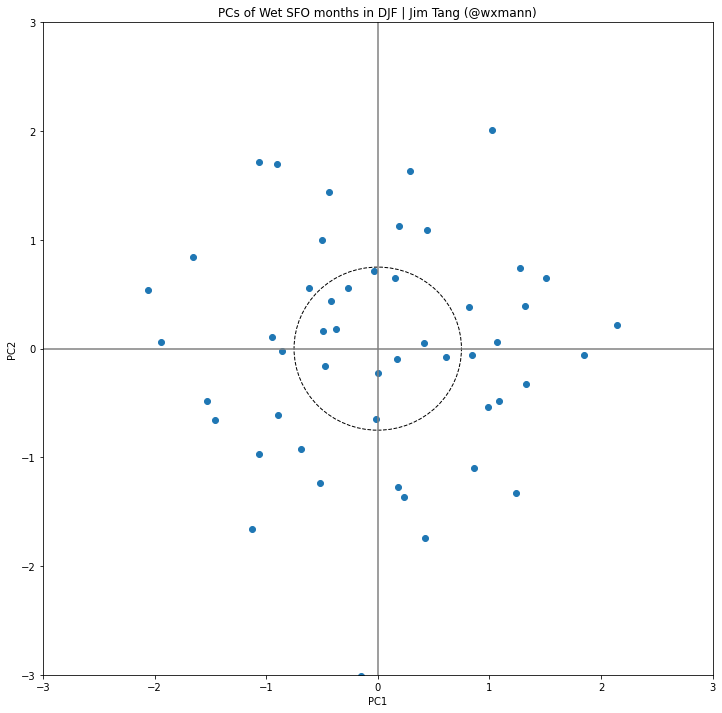

In [734]:
plt.figure(figsize=(12, 12))
plt.scatter(wet_with_pcs_djfm.pc1, wet_with_pcs_djfm.pc2)
plt.axhline(y=0, color='gray')
plt.axvline(x=0, color='gray')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCs of Wet SFO months in DJF | Jim Tang (@wxmann)')
circ = plt.Circle((0, 0), 0.75, color='k', fill=False, ls='--')
plt.gca().add_patch(circ)

## Analysis for just PC1 (Aleutian Region)

In [776]:
# analysis with just pc2 (Aleutian region)
threshold = 0.1

pc1_pos = wet_with_pcs_djfm[(wet_with_pcs_djfm.pc1 > threshold)]
pc1_neg = wet_with_pcs_djfm[(wet_with_pcs_djfm.pc1 < -threshold)]
_, _, pc1_pos_anoms = r1.hgt_monthly(500, yearmonths=pc1_pos.day, bbox=bbox)
_, _, pc1_neg_anoms = r1.hgt_monthly(500, yearmonths=pc1_neg.day, bbox=bbox)

In [801]:
default_levels = np.arange(-105, 106, 10)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


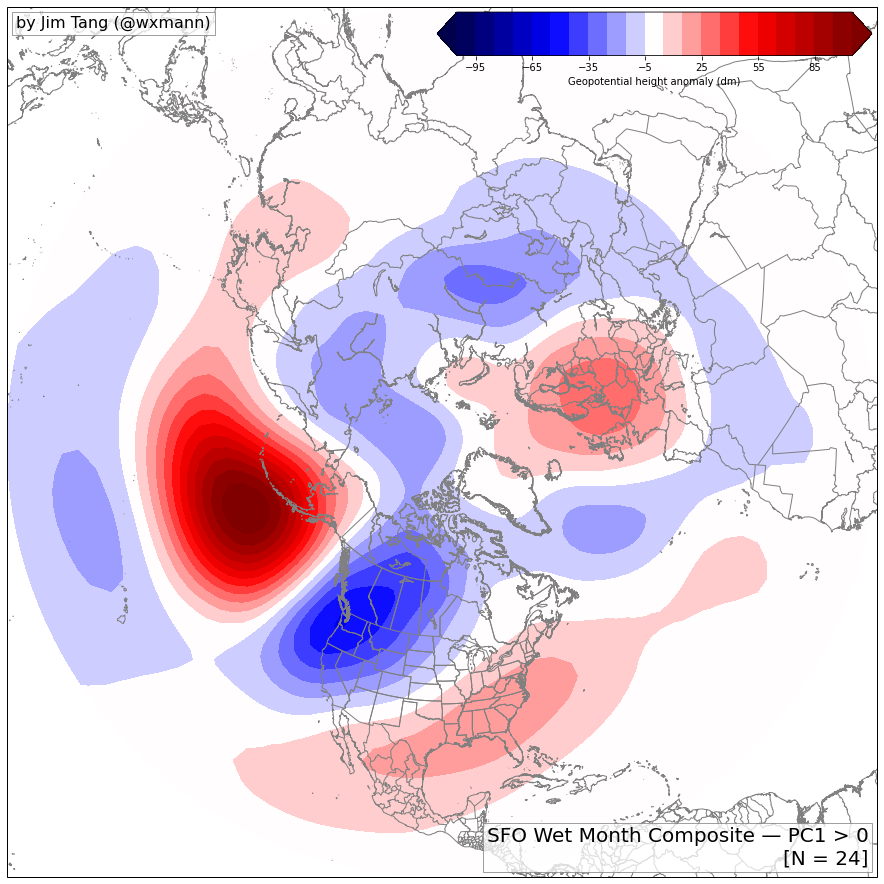

In [796]:
fig = plt.figure(figsize=(16, 16))

da = pc1_pos_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = default_levels
title = f'SFO Wet Month Composite — PC1 > {threshold}\n[N = {len(pc1_pos_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


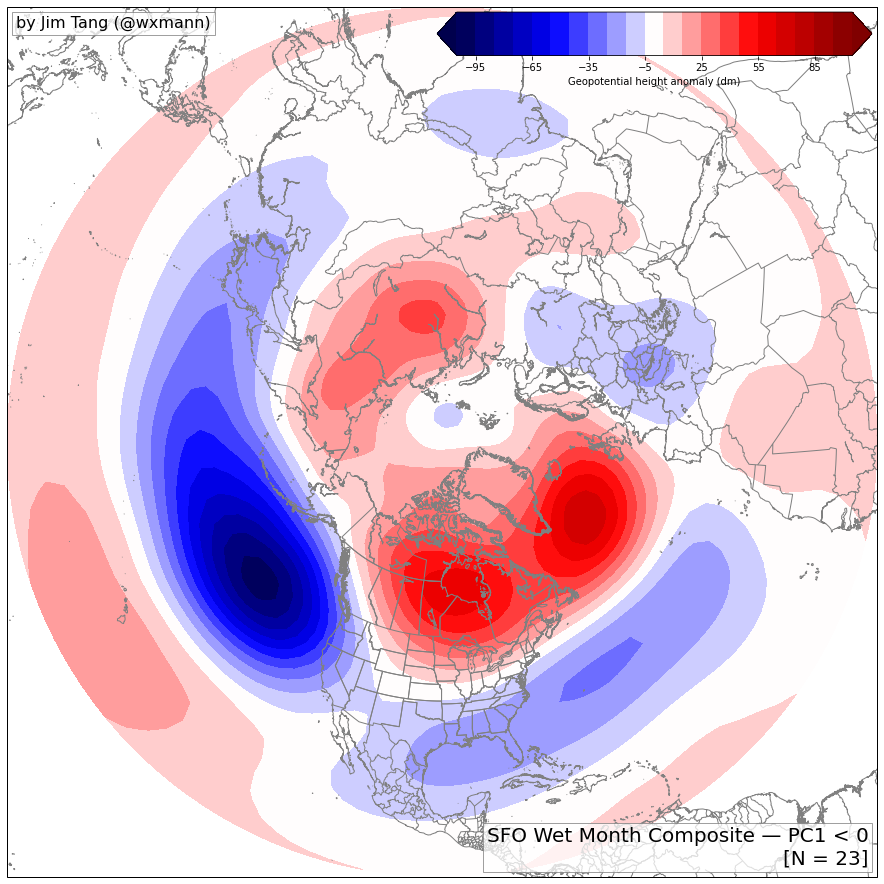

In [797]:
fig = plt.figure(figsize=(16, 16))

da = pc1_neg_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = default_levels
title = f'SFO Wet Month Composite — PC1 < {-threshold}\n[N = {len(pc1_neg_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

In [779]:
pc1_pos

day  precip_in  max_temp_anom  min_temp_anom  month  year   ONI  \
1  1993-01-01      11.07      -1.080645      -1.235484      1  1993  0.09   
3  2008-01-01       9.87      -3.269677      -0.520645      1  2008 -1.64   
5  2017-01-01       9.19       0.145161      -0.493548      1  2017 -0.34   
6  1982-01-01       8.80      -5.145161      -5.235484      1  1982 -0.05   
15 1982-03-01       7.49      -5.167742      -2.251613      3  1982  0.19   
17 2017-02-01       7.24       0.285714       2.875000      2  2017 -0.16   
18 2019-02-01       7.20      -3.607143      -2.232143      2  2019  0.72   
19 1996-01-01       6.84       0.758065       2.377419      1  1996 -0.90   
22 1996-12-01       6.49       2.274194       4.696774     12  1996 -0.49   
24 2004-12-01       6.26       1.403226       1.696774     12  2004  0.69   
25 2009-02-01       6.24      -1.392857      -0.267857      2  2009 -0.79   
26 2012-12-01       6.23       0.693548       1.793548     12  2012 -0.21   
27 1992-02-01       6.22       3.103448       2.941379      2  1992  1.63   
29 1983-12-01       6.03       0.661290       4.954839     12  1983 -0.91   
30 2001-02-01       5.98      -3.071429      -1.267857      2  2001 -0.52   
31 1991-03-01       5.96      -4.361290      -1.122581      3  1991  0.22   
33 1992-12-01       5.92      -1.403226      -0.529032     12  1992 -0.13   
34 1986-03-01       5.83       1.670968       2.522581      3  1986 -0.31   
38 2000-01-01       5.65       1.145161       3.474194      1  2000 -1.66   
39 2006-03-01       5.63      -5.167742      -3.896774      3  2006 -0.57   
42 1994-02-01       5.12      -2.964286      -1.839286      2  1994  0.07   
46 2011-02-01       4.79      -1.321429      -3.303571      2  2011 -1.19   
47 2012-03-01       4.67      -2.135484      -1.187097      3  2012 -0.59   
49 2016-12-01       4.51       0.080645      -2.432258     12  2016 -0.56   

         time       pc1       pc2  
1  1993-01-01  1.027835  2.009890  
3  2008-01-01  1.069775  0.064977  
5  2017-01-01  0.173637 -0.092317  
6  1982-01-01  0.988494 -0.537649  
15 1982-03-01  1.321545  0.395256  
17 2017-02-01  0.411775  0.054666  
18 2019-02-01  1.846553 -0.058903  
19 1996-01-01  0.859043 -1.098749  
22 1996-12-01  0.181295 -1.270917  
24 2004-12-01  0.441971  1.089603  
25 2009-02-01  1.237711 -1.328443  
26 2012-12-01  0.238082 -1.365410  
27 1992-02-01  0.193240  1.131690  
29 1983-12-01  0.158267  0.645360  
30 2001-02-01  0.611263 -0.080797  
31 1991-03-01  1.088985 -0.478963  
33 1992-12-01  1.278194  0.739069  
34 1986-03-01  0.285032  1.630300  
38 2000-01-01  0.844520 -0.055014  
39 2006-03-01  0.421450 -1.741758  
42 1994-02-01  1.325122 -0.325138  
46 2011-02-01  2.143074  0.221304  
47 2012-03-01  0.815418  0.386547  
49 2016-12-01  1.505661  0.651137

In [780]:
pc1_neg

day  precip_in  max_temp_anom  min_temp_anom  month  year   ONI  \
0  1998-02-01      13.52      -2.785714       1.446429      2  1998  1.93   
2  2014-12-01      10.47       4.983871       7.341935     12  2014  0.66   
4  2002-12-01       9.37       1.177419       3.019355     12  2002  1.14   
7  1995-01-01       8.76      -0.241935       4.216129      1  1995  0.96   
8  1995-03-01       8.63      -2.070968      -0.025806      3  1995  0.53   
9  2001-12-01       8.27      -0.564516       2.664516     12  2001 -0.31   
10 1983-03-01       8.26      -3.103226       1.490323      3  1983  1.54   
11 2005-12-01       8.17       2.435484       3.277419     12  2005 -0.84   
12 2000-02-01       8.15      -1.724138       2.458621      2  2000 -1.41   
13 1986-02-01       7.87       2.642857       4.339286      2  1986 -0.47   
14 1998-01-01       7.77       0.983871       4.312903      1  1998  2.24   
16 1997-01-01       7.35      -1.177419       2.119355      1  1997 -0.50   
20 1983-01-01       6.75      -2.758065      -1.332258      1  1983  2.18   
21 1983-02-01       6.55      -1.178571       1.982143      2  1983  1.92   
23 1995-12-01       6.27       1.983871       4.212903     12  1995 -0.98   
28 2003-12-01       6.09       0.306452       2.277419     12  2003  0.35   
32 2010-01-01       5.94      -0.661290       2.635484      1  2010  1.50   
35 2010-12-01       5.80       0.112903       2.890323     12  2010 -1.59   
37 1981-01-01       5.72       0.306452       1.248387      1  1981 -0.26   
40 2016-01-01       5.31       0.693548       4.183871      1  2016  2.48   
43 2016-03-01       5.05       1.767742       3.877419      3  2016  1.58   
44 2005-02-01       4.82       0.857143       3.267857      2  2005  0.58   
48 1993-02-01       4.54      -1.392857       0.767857      2  1993  0.30   

         time       pc1       pc2  
0  1998-02-01 -1.064628  1.712914  
2  2014-12-01 -0.613977  0.557409  
4  2002-12-01 -0.476651 -0.155552  
7  1995-01-01 -0.944172  0.103202  
8  1995-03-01 -0.372555  0.178833  
9  2001-12-01 -0.687800 -0.926079  
10 1983-03-01 -1.652597  0.846410  
11 2005-12-01 -1.532770 -0.485610  
12 2000-02-01 -0.438101  1.438559  
13 1986-02-01 -1.061039 -0.972472  
14 1998-01-01 -0.894360 -0.611413  
16 1997-01-01 -0.266934  0.562307  
20 1983-01-01 -0.899143  1.698774  
21 1983-02-01 -1.938296  0.064480  
23 1995-12-01 -0.857579 -0.023447  
28 2003-12-01 -0.420072  0.436671  
32 2010-01-01 -1.124904 -1.655656  
35 2010-12-01 -0.149588 -3.007787  
37 1981-01-01 -2.059972  0.541521  
40 2016-01-01 -1.459274 -0.653015  
43 2016-03-01 -0.486952  0.161652  
44 2005-02-01 -0.520461 -1.237001  
48 1993-02-01 -0.495181  0.998260

In [781]:
wet_with_pcs_djfm[wet_with_pcs_djfm.pc1.abs() < threshold]

day  precip_in  max_temp_anom  min_temp_anom  month  year   ONI  \
36 1996-02-01       5.75       0.758621       2.837931      2  1996 -0.75   
41 2011-03-01       5.13      -2.232258      -0.154839      3  2011 -0.93   
45 2018-01-01       4.82       2.822581       3.893548      1  2018 -0.92   

         time       pc1       pc2  
36 1996-02-01 -0.000965 -0.224131  
41 2011-03-01 -0.030903  0.716175  
45 2018-01-01 -0.019069 -0.650747

Text(2.2, 2, 'El Nino')

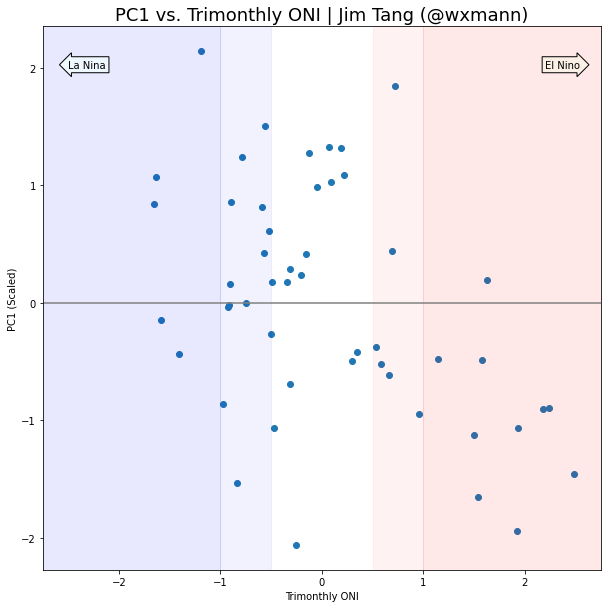

In [758]:
plt.figure(figsize=(10, 10))

plt.scatter(wet_with_pcs_djfm.ONI, wet_with_pcs_djfm.pc1)
plt.title('PC1 vs. Trimonthly ONI | Jim Tang (@wxmann)', fontdict=dict(fontsize=18))
plt.xlabel('Trimonthly ONI')
plt.ylabel('PC1 (Scaled)')
plt.axhline(y=0, color='gray')

# plt.axvline(x=1, color='gray', ls='--')
plt.axvspan(1, 3, color='red', alpha=0.09)

# plt.axvline(x=-1, color='gray', ls='--')
plt.axvspan(-1, -3, color='blue', alpha=0.09)

# plt.axvline(x=0.5, color='gray', ls='--')
plt.axvspan(0.5, 1, color='red', alpha=0.05)

# plt.axvline(x=-0.5, color='gray', ls='--')
plt.axvspan(-0.5, -1, color='blue', alpha=0.05)

plt.xlim([-2.75, 2.75])

plt.text(-2.5, 2, 'La Nina', bbox=dict(boxstyle='larrow,pad=0.3', fc='aliceblue'))
plt.text(2.2, 2, 'El Nino', bbox=dict(boxstyle='rarrow,pad=0.3', fc='linen'))

(-2.75, 2.75)

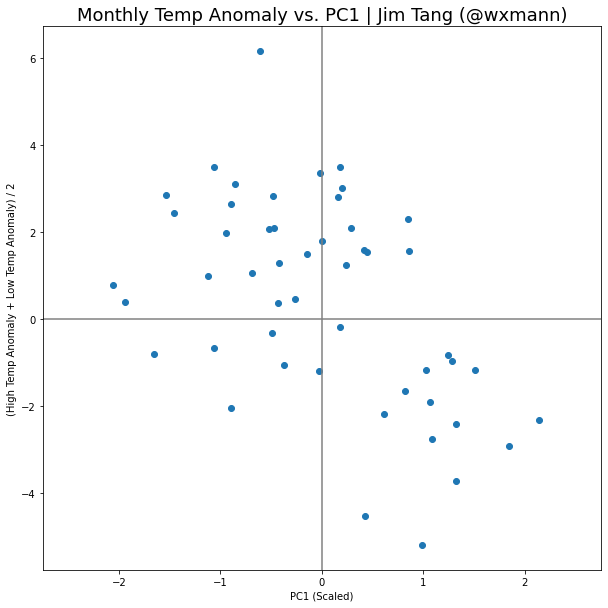

In [760]:
temp_anoms = (wet_with_pcs_djfm.max_temp_anom + wet_with_pcs_djfm.min_temp_anom) / 2

plt.figure(figsize=(10, 10))
plt.scatter(wet_with_pcs_djfm.pc1, temp_anoms)
plt.title('Monthly Temp Anomaly vs. PC1 | Jim Tang (@wxmann)', fontdict=dict(fontsize=18))
plt.ylabel('(High Temp Anomaly + Low Temp Anomaly) / 2')
plt.xlabel('PC1 (Scaled)')

plt.axhline(y=0, color='gray')
plt.axvline(x=0, color='gray')

plt.xlim([-2.75, 2.75])

In [782]:
warm_pos_pc1 = wet_with_pcs_djfm[(wet_with_pcs_djfm.pc1 > threshold) & (temp_anoms > 0)]
warm_pos_pc1

day  precip_in  max_temp_anom  min_temp_anom  month  year   ONI  \
17 2017-02-01       7.24       0.285714       2.875000      2  2017 -0.16   
19 1996-01-01       6.84       0.758065       2.377419      1  1996 -0.90   
22 1996-12-01       6.49       2.274194       4.696774     12  1996 -0.49   
24 2004-12-01       6.26       1.403226       1.696774     12  2004  0.69   
26 2012-12-01       6.23       0.693548       1.793548     12  2012 -0.21   
27 1992-02-01       6.22       3.103448       2.941379      2  1992  1.63   
29 1983-12-01       6.03       0.661290       4.954839     12  1983 -0.91   
34 1986-03-01       5.83       1.670968       2.522581      3  1986 -0.31   
38 2000-01-01       5.65       1.145161       3.474194      1  2000 -1.66   

         time       pc1       pc2  
17 2017-02-01  0.411775  0.054666  
19 1996-01-01  0.859043 -1.098749  
22 1996-12-01  0.181295 -1.270917  
24 2004-12-01  0.441971  1.089603  
26 2012-12-01  0.238082 -1.365410  
27 1992-02-01  0.193240  1.131690  
29 1983-12-01  0.158267  0.645360  
34 1986-03-01  0.285032  1.630300  
38 2000-01-01  0.844520 -0.055014

In [783]:
cold_pos_pc1 = wet_with_pcs_djfm[(wet_with_pcs_djfm.pc1 > threshold) & (temp_anoms < 0)]
cold_pos_pc1

day  precip_in  max_temp_anom  min_temp_anom  month  year   ONI  \
1  1993-01-01      11.07      -1.080645      -1.235484      1  1993  0.09   
3  2008-01-01       9.87      -3.269677      -0.520645      1  2008 -1.64   
5  2017-01-01       9.19       0.145161      -0.493548      1  2017 -0.34   
6  1982-01-01       8.80      -5.145161      -5.235484      1  1982 -0.05   
15 1982-03-01       7.49      -5.167742      -2.251613      3  1982  0.19   
18 2019-02-01       7.20      -3.607143      -2.232143      2  2019  0.72   
25 2009-02-01       6.24      -1.392857      -0.267857      2  2009 -0.79   
30 2001-02-01       5.98      -3.071429      -1.267857      2  2001 -0.52   
31 1991-03-01       5.96      -4.361290      -1.122581      3  1991  0.22   
33 1992-12-01       5.92      -1.403226      -0.529032     12  1992 -0.13   
39 2006-03-01       5.63      -5.167742      -3.896774      3  2006 -0.57   
42 1994-02-01       5.12      -2.964286      -1.839286      2  1994  0.07   
46 2011-02-01       4.79      -1.321429      -3.303571      2  2011 -1.19   
47 2012-03-01       4.67      -2.135484      -1.187097      3  2012 -0.59   
49 2016-12-01       4.51       0.080645      -2.432258     12  2016 -0.56   

         time       pc1       pc2  
1  1993-01-01  1.027835  2.009890  
3  2008-01-01  1.069775  0.064977  
5  2017-01-01  0.173637 -0.092317  
6  1982-01-01  0.988494 -0.537649  
15 1982-03-01  1.321545  0.395256  
18 2019-02-01  1.846553 -0.058903  
25 2009-02-01  1.237711 -1.328443  
30 2001-02-01  0.611263 -0.080797  
31 1991-03-01  1.088985 -0.478963  
33 1992-12-01  1.278194  0.739069  
39 2006-03-01  0.421450 -1.741758  
42 1994-02-01  1.325122 -0.325138  
46 2011-02-01  2.143074  0.221304  
47 2012-03-01  0.815418  0.386547  
49 2016-12-01  1.505661  0.651137

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


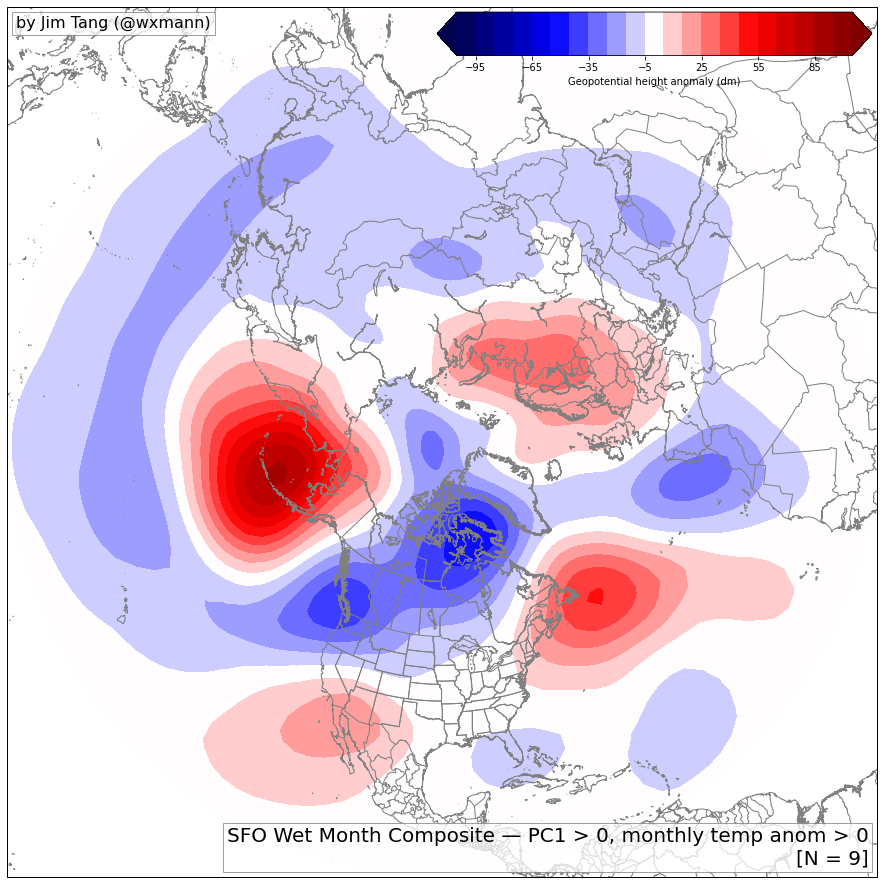

In [798]:
fig = plt.figure(figsize=(16, 16))

_, _, warm_pos_pc1_anoms = r1.hgt_monthly(500, yearmonths=warm_pos_pc1.day, bbox=bbox)
da = warm_pos_pc1_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = default_levels
title = f'SFO Wet Month Composite — PC1 > {threshold}, monthly temp anom > 0\n[N = {len(warm_pos_pc1_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


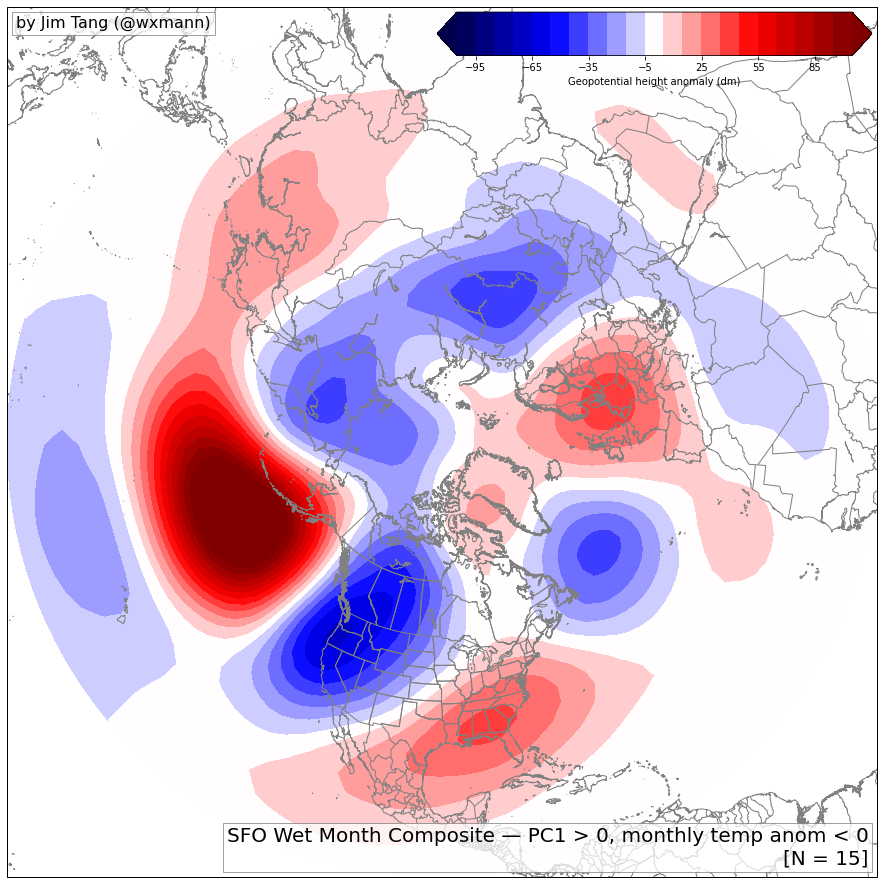

In [799]:
fig = plt.figure(figsize=(16, 16))

_, _, cold_pos_pc1_anoms = r1.hgt_monthly(500, yearmonths=cold_pos_pc1.day, bbox=bbox)
da = cold_pos_pc1_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = default_levels
title = f'SFO Wet Month Composite — PC1 > {threshold}, monthly temp anom < 0\n[N = {len(cold_pos_pc1_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

## Analysis Per Quadrant

In [786]:
min_amplitude = 0.5
cod = wet_with_pcs.pc1 ** 2 + wet_with_pcs.pc2 ** 2 < min_amplitude ** 2
threshold = 0

# analysis with four quandrants
q1 = wet_with_pcs[(wet_with_pcs.pc1 > threshold) & (wet_with_pcs.pc2 > threshold) & ~cod]
_, _, q1_anoms = r1.hgt_monthly(500, yearmonths=q1.day, bbox=bbox)

q2 = wet_with_pcs[(wet_with_pcs.pc1 < -threshold) & (wet_with_pcs.pc2 > threshold) & ~cod]
_, _, q2_anoms = r1.hgt_monthly(500, yearmonths=q2.day, bbox=bbox)

q3 = wet_with_pcs[(wet_with_pcs.pc1 < -threshold) & (wet_with_pcs.pc2 < -threshold) & ~cod]
_, _, q3_anoms = r1.hgt_monthly(500, yearmonths=q3.day, bbox=bbox)

q4 = wet_with_pcs[(wet_with_pcs.pc1 > threshold) & (wet_with_pcs.pc2 < -threshold) & ~cod]
_, _, q4_anoms = r1.hgt_monthly(500, yearmonths=q4.day, bbox=bbox)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


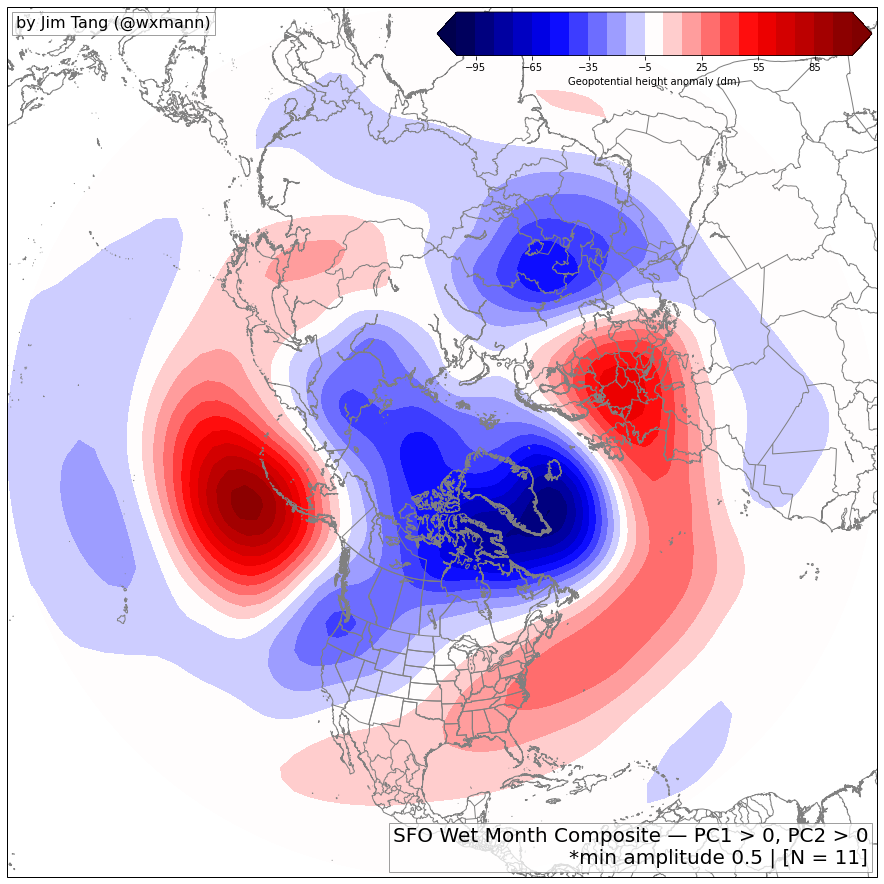

In [802]:
fig = plt.figure(figsize=(16, 16))

da = q1_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = default_levels
title = f'SFO Wet Month Composite — PC1 > 0, PC2 > 0\n*min amplitude {min_amplitude} | [N = {len(q1_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


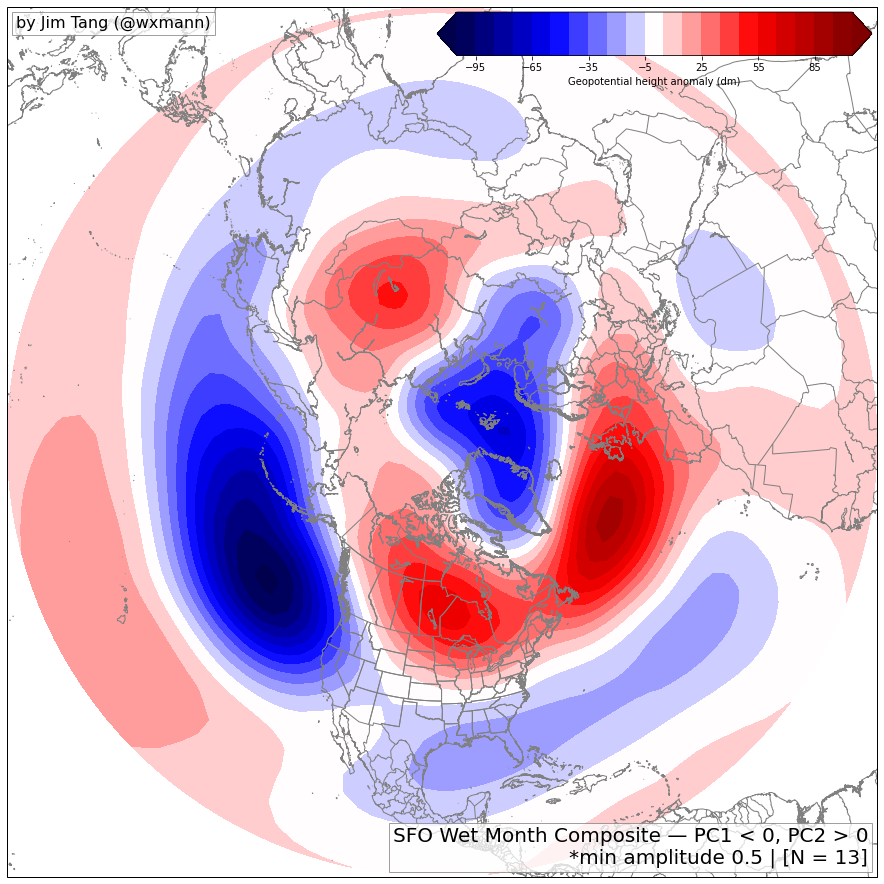

In [803]:
fig = plt.figure(figsize=(16, 16))

da = q2_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = default_levels
title = f'SFO Wet Month Composite — PC1 < 0, PC2 > 0\n*min amplitude {min_amplitude} | [N = {len(q2_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


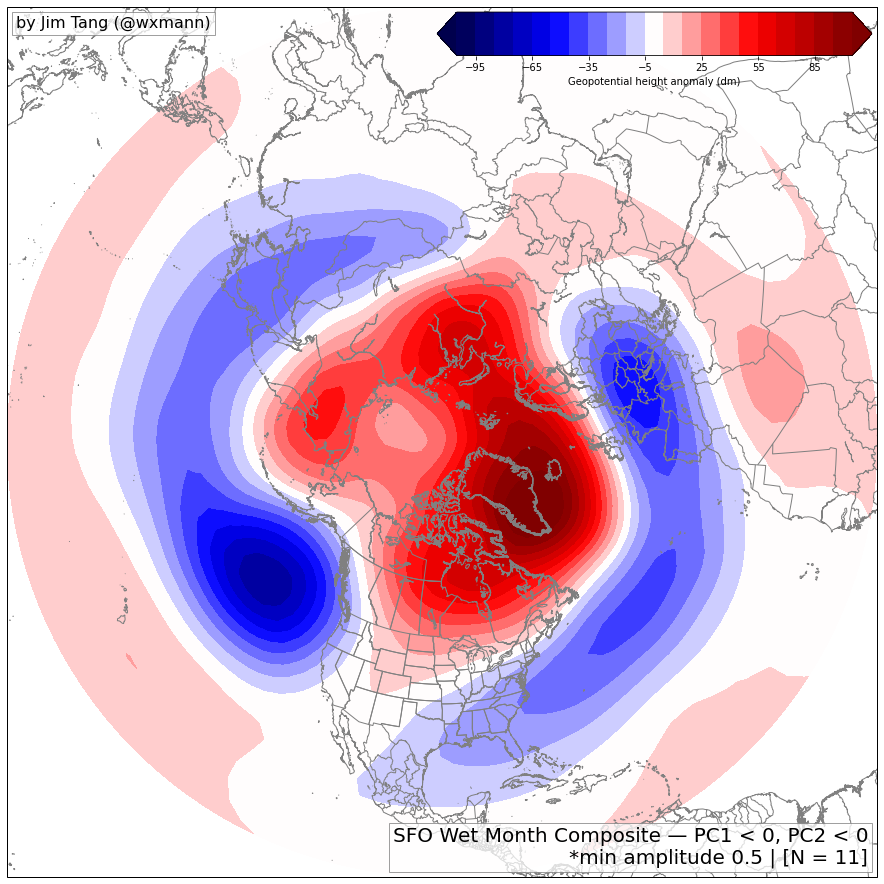

In [804]:
fig = plt.figure(figsize=(16, 16))

da = q3_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = default_levels
title = f'SFO Wet Month Composite — PC1 < 0, PC2 < 0\n*min amplitude {min_amplitude} | [N = {len(q3_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


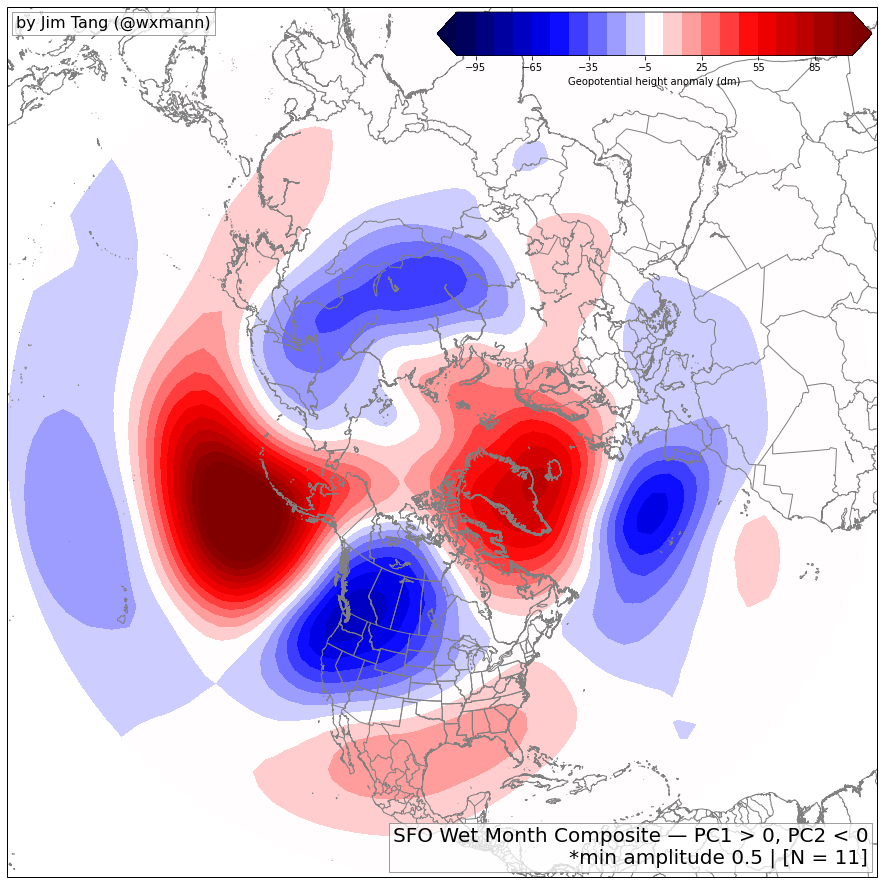

In [805]:
fig = plt.figure(figsize=(16, 16))

da = q4_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = default_levels
title = f'SFO Wet Month Composite — PC1 > 0, PC2 < 0\n*min amplitude {min_amplitude} | [N = {len(q4_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

In [791]:
q1

day  precip_in  max_temp_anom  min_temp_anom  month  year   ONI  \
1  1993-01-01      11.07      -1.080645      -1.235484      1  1993  0.09   
3  2008-01-01       9.87      -3.269677      -0.520645      1  2008 -1.64   
15 1982-03-01       7.49      -5.167742      -2.251613      3  1982  0.19   
24 2004-12-01       6.26       1.403226       1.696774     12  2004  0.69   
27 1992-02-01       6.22       3.103448       2.941379      2  1992  1.63   
29 1983-12-01       6.03       0.661290       4.954839     12  1983 -0.91   
33 1992-12-01       5.92      -1.403226      -0.529032     12  1992 -0.13   
34 1986-03-01       5.83       1.670968       2.522581      3  1986 -0.31   
46 2011-02-01       4.79      -1.321429      -3.303571      2  2011 -1.19   
47 2012-03-01       4.67      -2.135484      -1.187097      3  2012 -0.59   
49 2016-12-01       4.51       0.080645      -2.432258     12  2016 -0.56   

         time       pc1       pc2  
1  1993-01-01  1.027835  2.009890  
3  2008-01-01  1.069775  0.064977  
15 1982-03-01  1.321545  0.395256  
24 2004-12-01  0.441971  1.089603  
27 1992-02-01  0.193240  1.131690  
29 1983-12-01  0.158267  0.645360  
33 1992-12-01  1.278194  0.739069  
34 1986-03-01  0.285032  1.630300  
46 2011-02-01  2.143074  0.221304  
47 2012-03-01  0.815418  0.386547  
49 2016-12-01  1.505661  0.651137

In [792]:
q2

day  precip_in  max_temp_anom  min_temp_anom  month  year   ONI  \
0  1998-02-01      13.52      -2.785714       1.446429      2  1998  1.93   
2  2014-12-01      10.47       4.983871       7.341935     12  2014  0.66   
7  1995-01-01       8.76      -0.241935       4.216129      1  1995  0.96   
10 1983-03-01       8.26      -3.103226       1.490323      3  1983  1.54   
12 2000-02-01       8.15      -1.724138       2.458621      2  2000 -1.41   
16 1997-01-01       7.35      -1.177419       2.119355      1  1997 -0.50   
20 1983-01-01       6.75      -2.758065      -1.332258      1  1983  2.18   
21 1983-02-01       6.55      -1.178571       1.982143      2  1983  1.92   
28 2003-12-01       6.09       0.306452       2.277419     12  2003  0.35   
37 1981-01-01       5.72       0.306452       1.248387      1  1981 -0.26   
41 2011-03-01       5.13      -2.232258      -0.154839      3  2011 -0.93   
43 2016-03-01       5.05       1.767742       3.877419      3  2016  1.58   
48 1993-02-01       4.54      -1.392857       0.767857      2  1993  0.30   

         time       pc1       pc2  
0  1998-02-01 -1.064628  1.712914  
2  2014-12-01 -0.613977  0.557409  
7  1995-01-01 -0.944172  0.103202  
10 1983-03-01 -1.652597  0.846410  
12 2000-02-01 -0.438101  1.438559  
16 1997-01-01 -0.266934  0.562307  
20 1983-01-01 -0.899143  1.698774  
21 1983-02-01 -1.938296  0.064480  
28 2003-12-01 -0.420072  0.436671  
37 1981-01-01 -2.059972  0.541521  
41 2011-03-01 -0.030903  0.716175  
43 2016-03-01 -0.486952  0.161652  
48 1993-02-01 -0.495181  0.998260

In [793]:
q3

day  precip_in  max_temp_anom  min_temp_anom  month  year   ONI  \
4  2002-12-01       9.37       1.177419       3.019355     12  2002  1.14   
9  2001-12-01       8.27      -0.564516       2.664516     12  2001 -0.31   
11 2005-12-01       8.17       2.435484       3.277419     12  2005 -0.84   
13 1986-02-01       7.87       2.642857       4.339286      2  1986 -0.47   
14 1998-01-01       7.77       0.983871       4.312903      1  1998  2.24   
23 1995-12-01       6.27       1.983871       4.212903     12  1995 -0.98   
32 2010-01-01       5.94      -0.661290       2.635484      1  2010  1.50   
35 2010-12-01       5.80       0.112903       2.890323     12  2010 -1.59   
40 2016-01-01       5.31       0.693548       4.183871      1  2016  2.48   
44 2005-02-01       4.82       0.857143       3.267857      2  2005  0.58   
45 2018-01-01       4.82       2.822581       3.893548      1  2018 -0.92   

         time       pc1       pc2  
4  2002-12-01 -0.476651 -0.155552  
9  2001-12-01 -0.687800 -0.926079  
11 2005-12-01 -1.532770 -0.485610  
13 1986-02-01 -1.061039 -0.972472  
14 1998-01-01 -0.894360 -0.611413  
23 1995-12-01 -0.857579 -0.023447  
32 2010-01-01 -1.124904 -1.655656  
35 2010-12-01 -0.149588 -3.007787  
40 2016-01-01 -1.459274 -0.653015  
44 2005-02-01 -0.520461 -1.237001  
45 2018-01-01 -0.019069 -0.650747

In [794]:
q4

day  precip_in  max_temp_anom  min_temp_anom  month  year   ONI  \
6  1982-01-01       8.80      -5.145161      -5.235484      1  1982 -0.05   
18 2019-02-01       7.20      -3.607143      -2.232143      2  2019  0.72   
19 1996-01-01       6.84       0.758065       2.377419      1  1996 -0.90   
22 1996-12-01       6.49       2.274194       4.696774     12  1996 -0.49   
25 2009-02-01       6.24      -1.392857      -0.267857      2  2009 -0.79   
26 2012-12-01       6.23       0.693548       1.793548     12  2012 -0.21   
30 2001-02-01       5.98      -3.071429      -1.267857      2  2001 -0.52   
31 1991-03-01       5.96      -4.361290      -1.122581      3  1991  0.22   
38 2000-01-01       5.65       1.145161       3.474194      1  2000 -1.66   
39 2006-03-01       5.63      -5.167742      -3.896774      3  2006 -0.57   
42 1994-02-01       5.12      -2.964286      -1.839286      2  1994  0.07   

         time       pc1       pc2  
6  1982-01-01  0.988494 -0.537649  
18 2019-02-01  1.846553 -0.058903  
19 1996-01-01  0.859043 -1.098749  
22 1996-12-01  0.181295 -1.270917  
25 2009-02-01  1.237711 -1.328443  
26 2012-12-01  0.238082 -1.365410  
30 2001-02-01  0.611263 -0.080797  
31 1991-03-01  1.088985 -0.478963  
38 2000-01-01  0.844520 -0.055014  
39 2006-03-01  0.421450 -1.741758  
42 1994-02-01  1.325122 -0.325138

{'whiskers': [<matplotlib.lines.Line2D at 0x14b8f62e0>,
 'caps': [<matplotlib.lines.Line2D at 0x14b8f69a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x14b9166d0>,
 'medians': [<matplotlib.lines.Line2D at 0x14b9130a0>,
 'fliers': [<matplotlib.lines.Line2D at 0x14b913400>,
 'means': []}

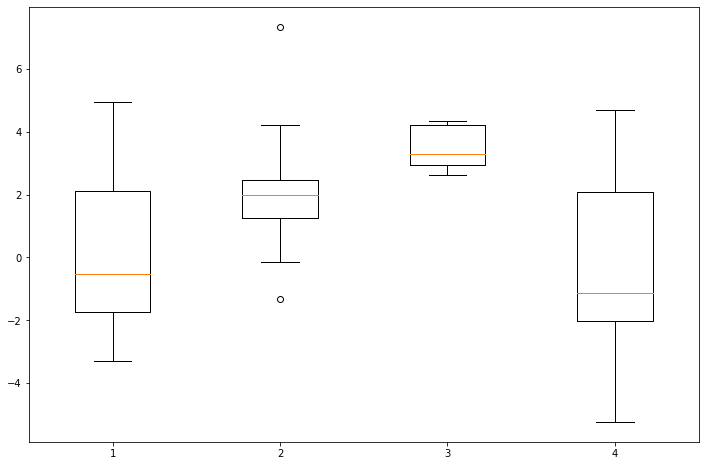

In [795]:
plt.figure(figsize=(12, 8))
plt.boxplot([q1.min_temp_anom, q2.min_temp_anom, q3.min_temp_anom, q4.min_temp_anom])